In [1]:
import copy
import random
import numpy as np
import scipy.io
from pyDOE import lhs

import torch
from torch import nn, optim, autograd

import torch.nn.init as init
from torch.nn import functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils_training_EC import *

#Paper reproduction
random_seed_set = 1234
set_random_seed(random_seed_set)

In [2]:
N_train = 5000
N_bound = 200

# x,t
la = np.array([1, 1])
lb = np.array([-1, 0])

traindata = lb + (la - lb) * lhs(2, N_train)
x_inside = traindata[:, 0:1]
t_inside = traindata[:, 1:2]

x_inside = numpy_to_tensor(x_inside,
                           var_name="x_inside",
                           value_range_dim=True,
                           to_torch=True,
                           to_cuda=True,
                           requires_grad=True)

t_inside = numpy_to_tensor(t_inside,
                           var_name="t_inside",
                           value_range_dim=True,
                           to_torch=True,
                           to_cuda=True,
                           requires_grad=True)

x_inside: Column 0: range from -0.9999233922198485 to 0.9998822478677367
t_inside: Column 0: range from 0.0001244217542079664 to 0.9999681727021804


In [3]:
from scipy.io import loadmat

data = loadmat("usol_D_0.001_k_5.mat")

t_exact = data["t"].reshape(-1, 1)

x_exact = data["x"].reshape(-1, 1)

Exact_u = data["u"]

print('t_exact:', t_exact.shape)
print('x_exact:', x_exact.shape)
print('Exact_u:', Exact_u.shape)

t_exact: (101, 1)
x_exact: (201, 1)
Exact_u: (101, 201)


In [4]:
X_exact, T_exact = np.meshgrid(x_exact, t_exact)
print('X_exact:', X_exact.shape)
print('T_exact:', T_exact.shape)

X_exact_flatten = X_exact.flatten()[:, None]
T_exact_flatten = T_exact.flatten()[:, None]
data_star = np.hstack((X_exact_flatten, T_exact_flatten))

u_star = Exact_u.flatten()[:, None]

X_exact: (101, 201)
T_exact: (101, 201)


In [5]:
data_star.shape

(20301, 2)

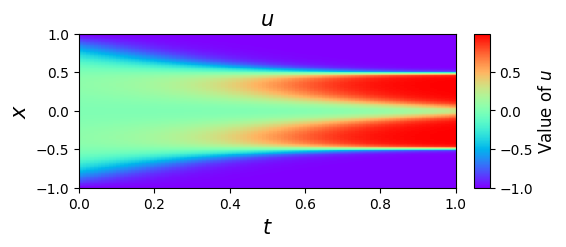

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 2))

cmap = plt.get_cmap('jet')
heatmap1 = ax1.imshow(Exact_u.T,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[0, 1, -1, 1],
                      origin='lower',
                      aspect='auto')

ax1.set_title(r'$u$', fontsize=15)
ax1.set_xlabel(r'$t$', fontsize=15)
ax1.set_ylabel(r'$x$', fontsize=15)

# Add a color bar
cbar = fig.colorbar(heatmap1, ax=ax1, fraction=0.15, pad=0.04, aspect=10)
cbar.set_label(r'Value of $u$', fontsize=12)

plt.show()

In [7]:
random_seed = 1234
np.random.seed(random_seed)
number_observe_data = 50

index_x = (lhs(1, number_observe_data)) * len(x_exact)
index_x = np.floor(index_x).reshape(number_observe_data, ).astype(int)
observe_x = x_exact[index_x]

index_t = (lhs(1, number_observe_data)) * len(t_exact)
index_t = np.floor(index_t).reshape(number_observe_data, ).astype(int)
observe_t = t_exact[index_t]

observe_data = np.hstack((observe_x, observe_t))
observe_clear_u = Exact_u[index_t, index_x].reshape(-1, 1)

############# N(0,0.1^2) #############
noise_nu = 0.0
noise_std = 0.1
noise_u = np.random.normal(loc=noise_nu, scale=noise_std, size=observe_clear_u.shape)
observe_u = observe_clear_u + noise_u
############# N(0,0.1^2) #############
#observe_u = observe_clear_u.copy()

observe_data = numpy_to_tensor(observe_data,
                               var_name="observe_data",
                               value_range_dim=True,
                               to_torch=True,
                               to_cuda=True,
                               requires_grad=True)

observe_clear_u = numpy_to_tensor(observe_clear_u,
                                  var_name="observe_u",
                                  value_range_dim=True,
                                  to_torch=True,
                                  to_cuda=True,
                                  requires_grad=True)

observe_u = numpy_to_tensor(observe_u,
                            var_name="observe_u",
                            value_range_dim=True,
                            to_torch=True,
                            to_cuda=True,
                            requires_grad=True)

noise_u = numpy_to_tensor(noise_u,
                            var_name="noise_u",
                            value_range_dim=True,
                            to_torch=True,
                            to_cuda=True,
                            requires_grad=False)

observe_data_x_inside = observe_data[:, 0:1]
observe_data_t_inside = observe_data[:, 1:2]

observe_data: Column 0: range from -1.0 to 0.99
observe_data: Column 1: range from 0.01 to 0.99
observe_u: Column 0: range from -1.0 to 0.9528342844289072
observe_u: Column 0: range from -1.1688576528993058 to 0.9875168124145501
noise_u: Column 0: range from -0.21688180517085787 to 0.43639188861570943


In [8]:
np.random.seed(5678)
n_test_data = 10000

index_x = (lhs(1, n_test_data)) * len(x_exact)
index_x = np.floor(index_x).reshape(n_test_data, ).astype(int)
test_data_x = x_exact[index_x]

index_t = (lhs(1, n_test_data)) * len(t_exact)
index_t = np.floor(index_t).reshape(n_test_data, ).astype(int)
test_data_t = t_exact[index_t]

test_data = np.hstack((test_data_x, test_data_t))
test_u = Exact_u[index_t, index_x].reshape(-1, 1)

test_data = numpy_to_tensor(test_data,
                            var_name="test_data",
                            value_range_dim=True,
                            to_torch=True,
                            to_cuda=True,
                            requires_grad=True)

test_u = numpy_to_tensor(test_u,
                         var_name="test_u",
                         value_range_dim=True,
                         to_torch=True,
                         to_cuda=True,
                         requires_grad=True)

test_data_x_inside = test_data[:, 0:1]
test_data_t_inside = test_data[:, 1:2]

test_data: Column 0: range from -1.0 to 1.0
test_data: Column 1: range from 0.0 to 1.0
test_u: Column 0: range from -1.0 to 0.9918199944816758


In [9]:
print('The number of observational data J:', len(observe_u))

The number of observational data J: 50


In [10]:
def output_transform(data_input, u_input):

    x_in = data_input[:, 0:1]
    t_in = data_input[:, 1:2]

    return x_in**2 * torch.cos(torch.tensor(np.pi) * x_in) + t_in * (1 - x_in**2) * u_input

In [11]:
def get_loss_f_1(x_grad, t_grad, PINNs, C, return_sequence='not'):

    E_inside = PINNs(torch.cat((x_grad, t_grad), dim=1))
    E_inside = output_transform(torch.cat((x_grad, t_grad), dim=1), E_inside)

    E_x = compute_higher_order_derivatives(E_inside, [x_grad])
    E_xx = compute_higher_order_derivatives(E_x, [x_grad])

    E_t = compute_higher_order_derivatives(E_inside, [t_grad])

    loss_term = E_t - C * E_xx - 5 * (E_inside - E_inside**3)

    if return_sequence == 'yes':
        return torch.square(loss_term)
    else:
        return torch.mean(torch.square(loss_term))

In [12]:
Theta_list = np.zeros_like(observe_u.cpu().detach().numpy())
Theta_list_1 = numpy_to_tensor(Theta_list,
                             var_name="Theta_list",
                             value_range_dim=True,
                             to_torch=True,
                             to_cuda=True,
                             requires_grad=True)

Theta_list_id = id(Theta_list_1)

optimizer_error = optim.Adam([Theta_list_1],
                             lr=0.0001,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0,
                             amsgrad=False)

Theta_list: Column 0: range from 0.0 to 0.0


In [13]:
x_inside_all = torch.cat((x_inside,observe_data[:,0:1]),dim=0)
t_inside_all = torch.cat((t_inside,observe_data[:,1:2]),dim=0)

In [14]:
data_inputs = {
    'x_inside_all': x_inside_all,
    't_inside_all': t_inside_all,
    'x_inside': x_inside,
    't_inside': t_inside,
    'observe_data': observe_data,
    'noise_u': noise_u,
    'observe_u': observe_u,
    'observe_clear_u': observe_clear_u,
    'observe_data_x_inside': observe_data_x_inside,
    'observe_data_t_inside': observe_data_t_inside,
    'test_data': test_data,
    'test_u': test_u,
    'test_data_x_inside': test_data_x_inside,
    'test_data_t_inside': test_data_t_inside,
    'C1': None,
}

In [15]:
#Paper reproduction
random_seed_set = 1234
set_random_seed(random_seed_set)

In [16]:
net_settings_for_PINNs_1 = NetSetting(input_dims=2,
                                     hidden_neurons_list=[64] * 6,
                                     output_dims=1,
                                     hidden_activation='tanh',
                                     output_activation=None,
                                     initializer_method='xavier')

PINNs_1 = get_mlp_pinn(net_settings_for_PINNs_1)
PINNs_1.cuda()

initialize_weights(PINNs_1, net_settings_for_PINNs_1.initializer_method)

optimizer_pinn = optim.Adam(PINNs_1.parameters(),
                        lr=0.001,
                        betas=(0.9, 0.999),
                        eps=1e-08,
                        weight_decay=0,
                        amsgrad=False)

C1 = torch.tensor(0.5, requires_grad=True)
C1_id = id(C1)
optimizer_pinn.add_param_group({'params': [C1], 'lr': 0.001})

In [17]:
tau = 50/2

AdaEC_scheduler = AdaEC_class(optimizer_pinn, optimizer_error,
                              min_lr=1e-8, max_lr=1e-4, adjustment_factor = 10,
                              patience_base = tau*2, patience_down = tau, patience_up = tau,
                              error_threshold = 1e-6)

In [18]:
nIter1 = 20000
it = 0
training_recorder_1 = training_recorder()

if_timing_point = False
loss_noise_elimination = torch.mean(torch.square(Theta_list_1 - noise_u))

while it < nIter1:
    #########loss f#########
    loss_f = get_loss_f_1(x_inside_all, t_inside_all, PINNs_1, C1)
    
    #########loss T noisy observation#########
    E_observation = PINNs_1(observe_data)
    E_observation = output_transform(observe_data, E_observation)
    loss_error_correction = torch.mean(torch.square(E_observation + Theta_list_1 - data_inputs['observe_u']))
    
    #########loss PI#########
    loss_all = loss_f + 10 * loss_error_correction 
    
    ######### Record #########
    data_inputs['C1'] = C1
    test_loss  = training_calculator(PINNs_1, get_loss_f_1, Theta_list_1,
                                     training_recorder_1, data_inputs, output_transform)
    
    if it % 1000 == 0:
        print(f"Iterations: {it}, train_loss: {loss_all.item():.8f}, test_loss: {test_loss:.6f}, noise_elimination_loss: {loss_noise_elimination:.6f}")
        change_C_learning_rate(optimizer_pinn, C1_id, learning_rate = None)
        print('Estimated parameter:',C1)
        change_EC_factors_learning_rate(optimizer_error, learning_rate = None)
        print('----------------------------------------------------------------')
    ######### Record #########
    
    optimizer_pinn.zero_grad()
    loss_all.backward()
    optimizer_pinn.step() 
    
    ############################ Recall #############################
    if if_timing_point == False:
        if it > 100:
            (PINNs, C, it, optimizer_pinn_input,
             if_timing_point) = training_recall(it, PINNs_1, C1,
                                                optimizer_pinn, training_recorder_1,
                                                if_timing_point, threshold = 0, window_wide = 500)
            if if_timing_point == True:
                change_C_learning_rate(optimizer_pinn, C1_id, learning_rate = 0.0001)
                
    else:
        AdaEC_scheduler.step(training_recorder_1, it, C1_id)
        Theta_list, loss_noise_elimination = train_for_error_correction(PINNs_1, C1, optimizer_error, 
                                                                        Theta_list_1, data_inputs,
                                                                        output_transform)
    ############################ Recall #############################
    
    it = it + 1
    
print(f"Final result: train_loss: {loss_all.item():.8f}, test_loss: {test_loss:.6f}, noise_elimination_loss: {loss_noise_elimination:.6f}")
print('Estimated parameter:',C1)

output_dir = f'../experimental_data/Allen_Cahn_tau_{tau}/AdaEC_N1/'
training_recorder_1.save(output_dir)

Iterations: 0, train_loss: 8.64710712, test_loss: 0.676072, noise_elimination_loss: 0.013325
Current C1 learning rate: 0.001
Estimated parameter: tensor(0.5000, requires_grad=True)
Current EC_factors learning rate: 0.0001
----------------------------------------------------------------
Iterations: 1000, train_loss: 0.16087157, test_loss: 0.119921, noise_elimination_loss: 0.013325
Current C1 learning rate: 0.001
Estimated parameter: tensor(0.0062, requires_grad=True)
Current EC_factors learning rate: 0.0001
----------------------------------------------------------------
Iterations: 2000, train_loss: 0.10033459, test_loss: 0.100835, noise_elimination_loss: 0.013325
Current C1 learning rate: 0.001
Estimated parameter: tensor(0.0018, requires_grad=True)
Current EC_factors learning rate: 0.0001
----------------------------------------------------------------
Restoring best model to the timing point: 1884
Current C1 learning rate: 0.0001
____________________New training stagnation__________

____________________New training stagnation____________________
____________________New training stagnation____________________
Iterations: 17000, train_loss: 0.00017945, test_loss: 0.057843, noise_elimination_loss: 0.000377
Current C1 learning rate: 0
Estimated parameter: tensor(0.0018, requires_grad=True)
Current EC_factors learning rate: 1e-05
----------------------------------------------------------------
____________________New training stagnation____________________
____________________New training stagnation____________________
____________________New training stagnation____________________
Iterations: 18000, train_loss: 0.00066264, test_loss: 0.058042, noise_elimination_loss: 0.000369
Current C1 learning rate: 0
Estimated parameter: tensor(0.0018, requires_grad=True)
Current EC_factors learning rate: 0.0001
----------------------------------------------------------------
____________________New training stagnation____________________
____________________New training stagnation